# Conformal Regression (Built on top of DER)
Romano+'s approach to quantile regression, these are heuristic.
Turn this into a score function, which we then calibrate with conformal prediction

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [5]:
DER_TYPE = 'DER'  # 'sDER'
norm = 'False' # if you normalize, rn the normalized version doesn't work

In [6]:
BATCH_SIZE = 100
N_SAMPLES = 50
N_EPOCHS = 500

if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
else:
    LR = .005    # learning rate
    COEFF = 2.   # lambda

In [7]:
if DER_TYPE == 'DER':
    DERLayer = models.DERLayer
    loss_der = models.loss_der
else:
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Generate data
This is the same as in the DeepEnsemble

In [8]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x_data)) 
    return m * x_data + b + ε

def simulator_no_noise(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    return m * x_data + b

In [9]:
x_data = np.linspace(0, 100, 101)

length_df = 1000
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

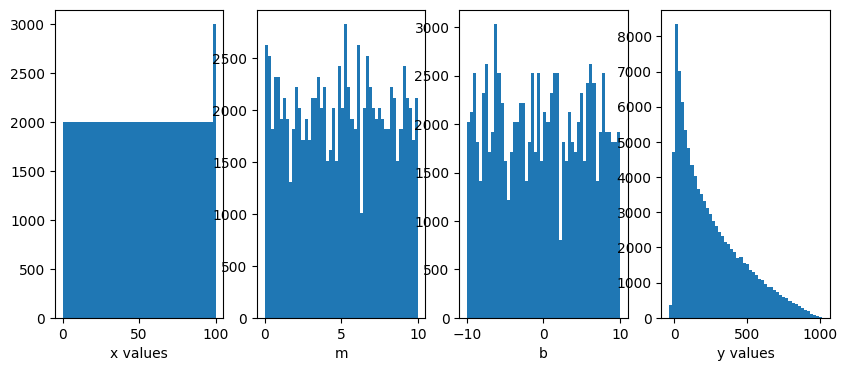

In [10]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [11]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [12]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

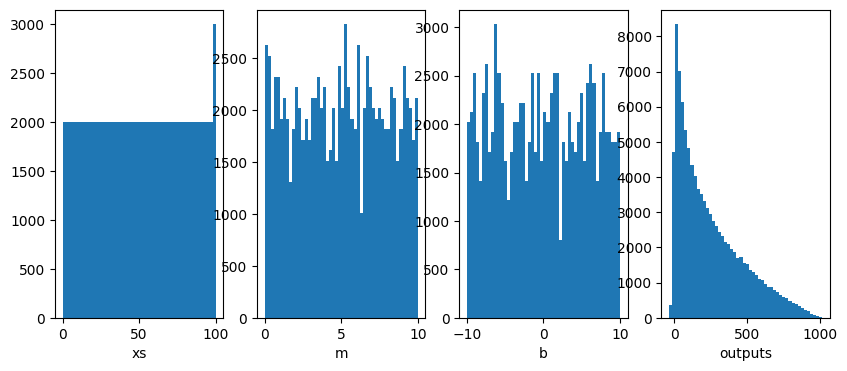

In [13]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


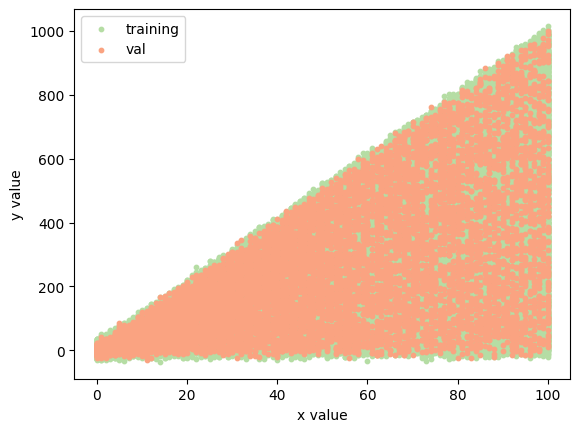

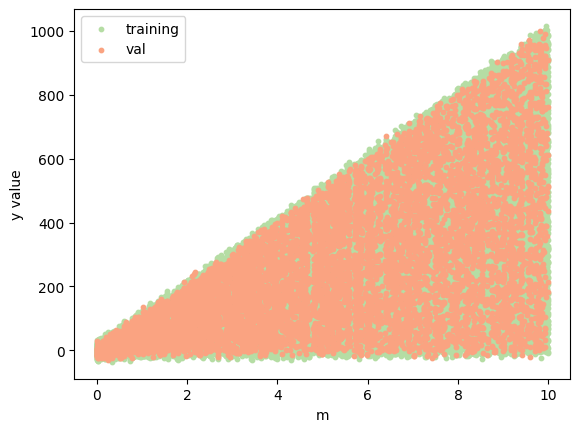

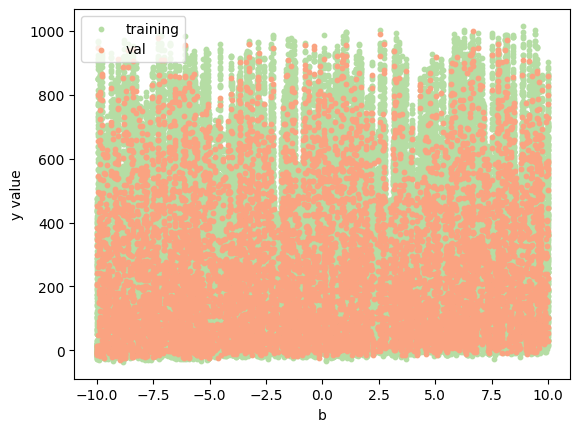

In [14]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [15]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


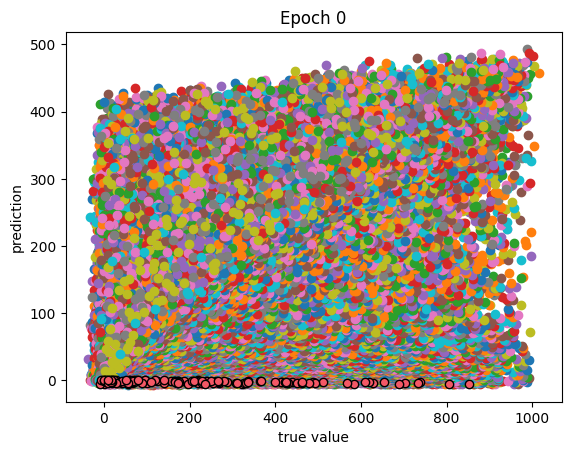

new best loss 7.159616947174072 in epoch 0
epoch 1 0.01
new best loss 5.372407913208008 in epoch 1
epoch 2 0.02
new best loss 4.879313945770264 in epoch 2
epoch 3 0.03
new best loss 4.594153881072998 in epoch 3
epoch 4 0.04
new best loss 4.37628173828125 in epoch 4
epoch 5 0.05


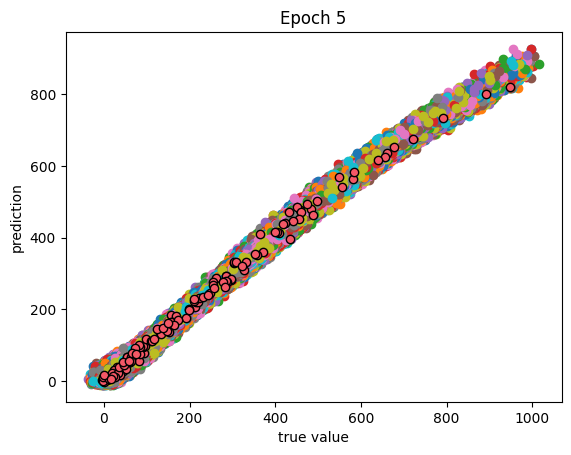

new best loss 4.205920219421387 in epoch 5
epoch 6 0.06
new best loss 4.125288486480713 in epoch 6
epoch 7 0.07
new best loss 4.050142288208008 in epoch 7
epoch 8 0.08
epoch 9 0.09
new best loss 3.972534418106079 in epoch 9
epoch 10 0.1


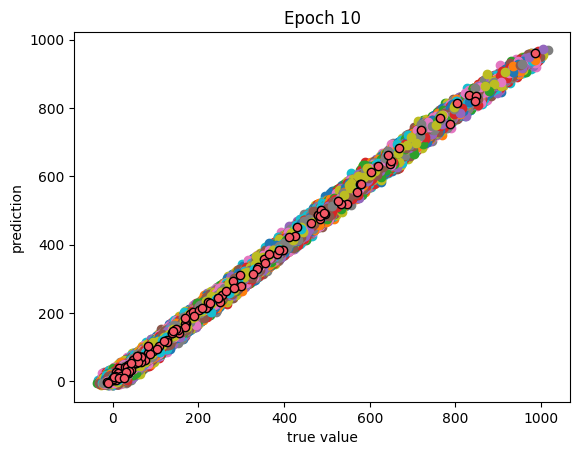

epoch 11 0.11
epoch 12 0.12
new best loss 3.9525506496429443 in epoch 12
epoch 13 0.13
epoch 14 0.14
new best loss 3.936056137084961 in epoch 14
epoch 15 0.15


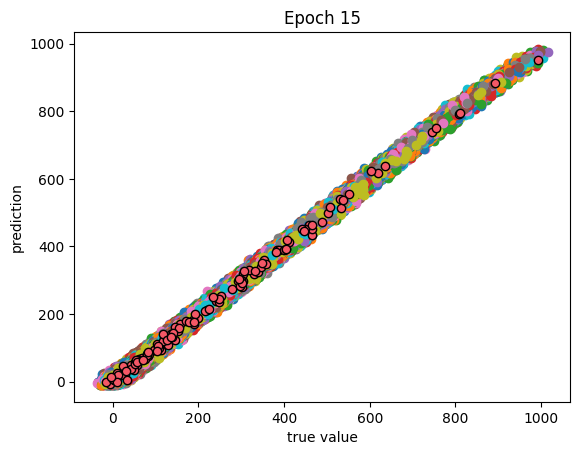

epoch 16 0.16
epoch 17 0.17
epoch 18 0.18
epoch 19 0.19
epoch 20 0.2


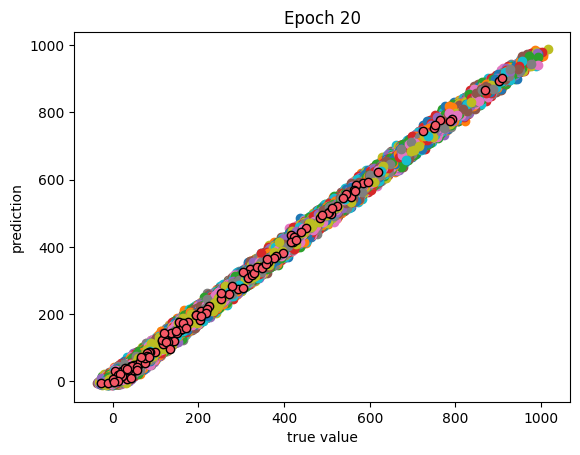

epoch 21 0.21
epoch 22 0.22
new best loss 3.907219171524048 in epoch 22
epoch 23 0.23
epoch 24 0.24
epoch 25 0.25


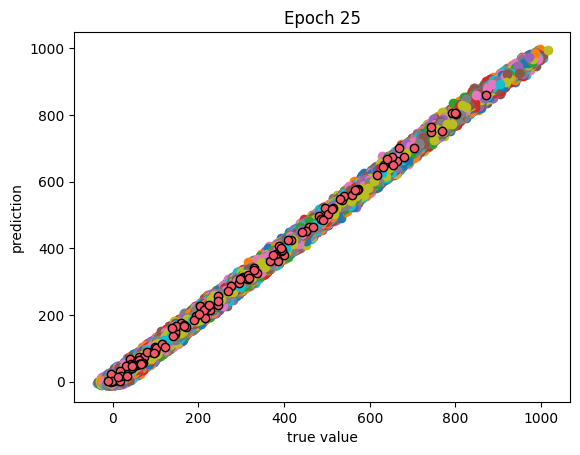

epoch 26 0.26
epoch 27 0.27
epoch 28 0.28
epoch 29 0.29
epoch 30 0.3


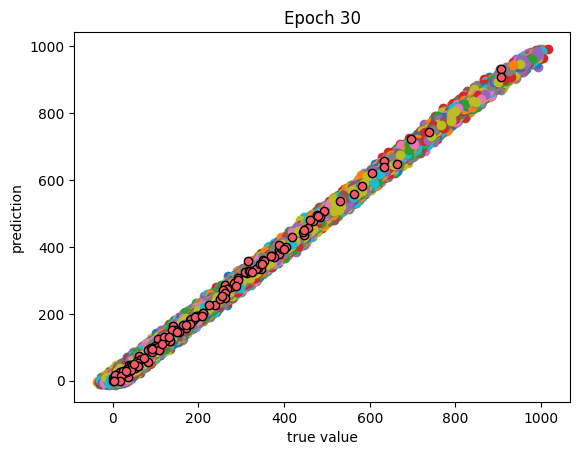

epoch 31 0.31
epoch 32 0.32
epoch 33 0.33
epoch 34 0.34
new best loss 3.9020707607269287 in epoch 34
epoch 35 0.35


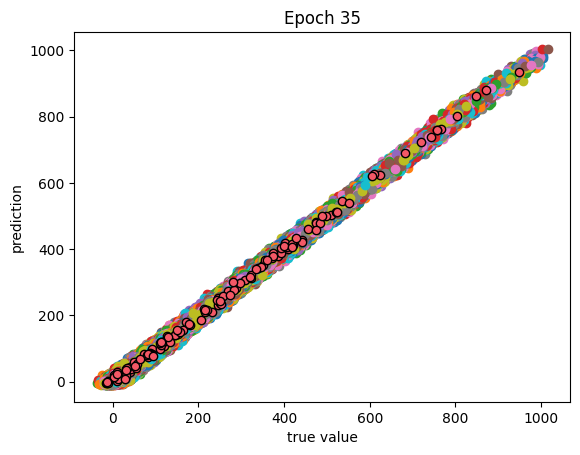

epoch 36 0.36
epoch 37 0.37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4


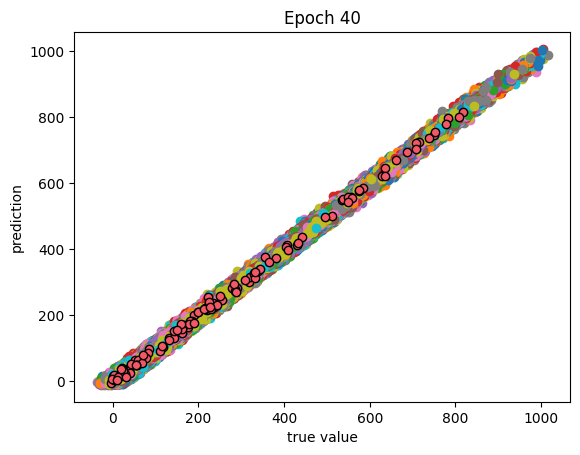

epoch 41 0.41
epoch 42 0.42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45


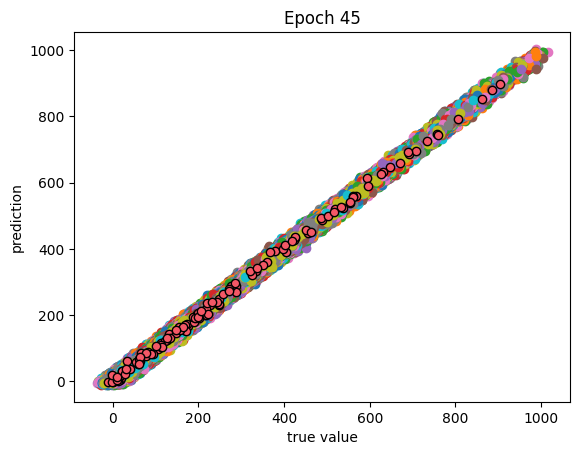

epoch 46 0.46
epoch 47 0.47
epoch 48 0.48
epoch 49 0.49
new best loss 3.8957557678222656 in epoch 49
epoch 50 0.5


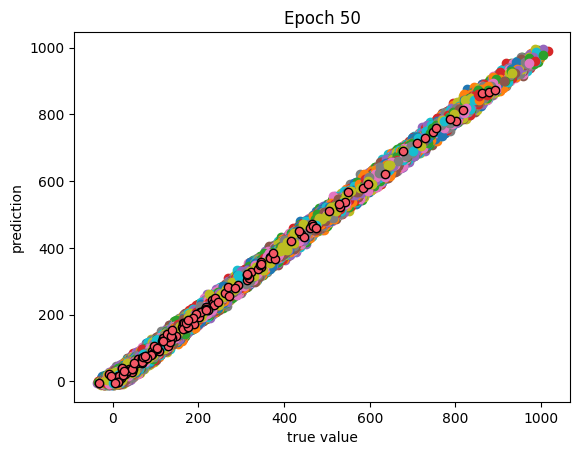

epoch 51 0.51
epoch 52 0.52
epoch 53 0.53
epoch 54 0.54
new best loss 3.894071102142334 in epoch 54
epoch 55 0.55


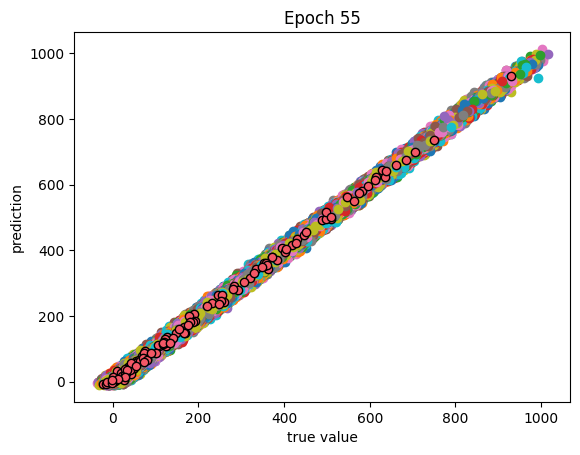

epoch 56 0.56
epoch 57 0.57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6


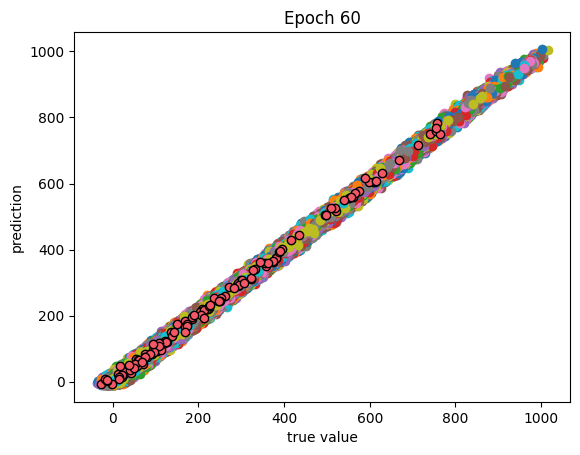

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65


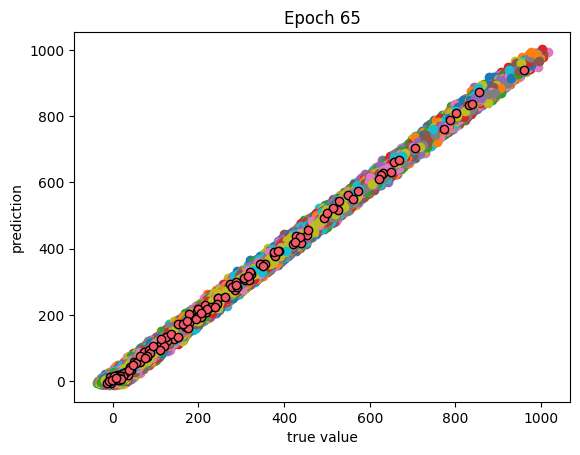

new best loss 3.8920297622680664 in epoch 65
epoch 66 0.66
epoch 67 0.67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7


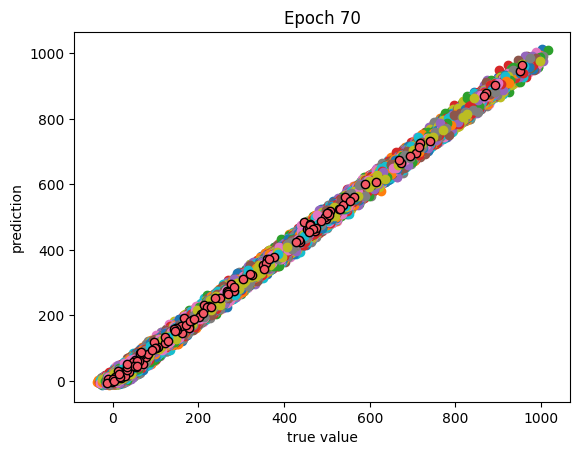

epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75


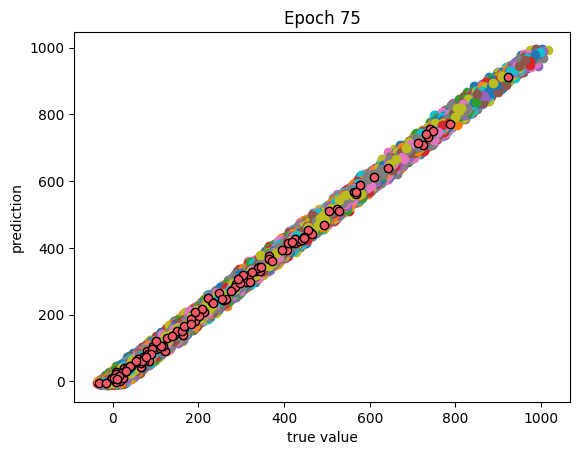

epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
new best loss 3.88346266746521 in epoch 78
epoch 79 0.79
epoch 80 0.8


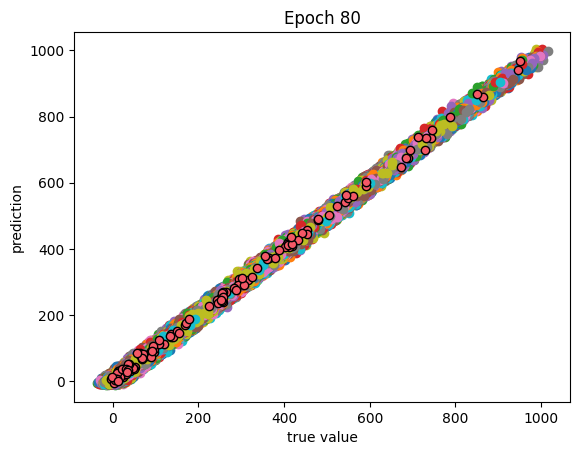

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85


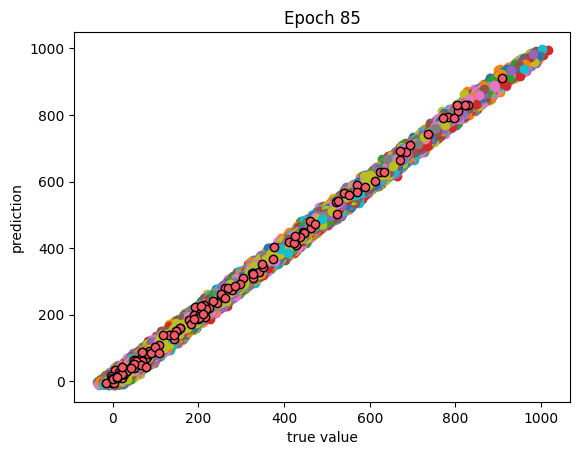

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9


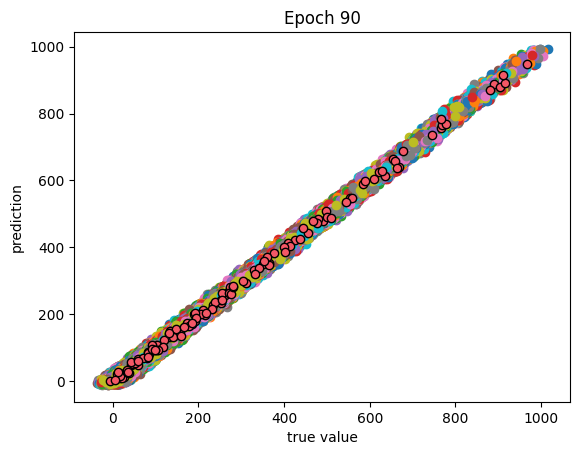

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95


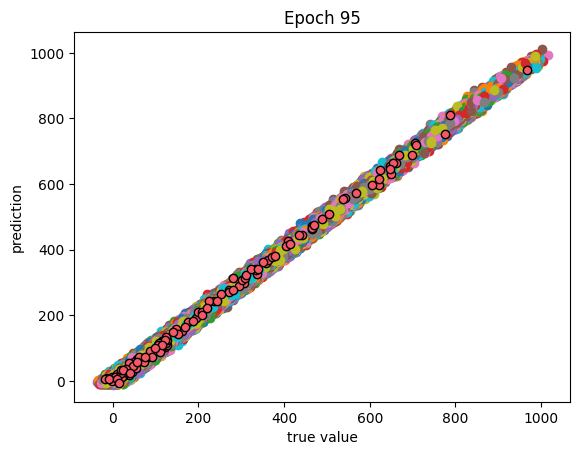

epoch 96 0.96
epoch 97 0.97
epoch 98 0.98
epoch 99 0.99
start at 1704314249.191222 end at 1704314343.1097012
93.91847920417786


<Figure size 640x480 with 0 Axes>

In [16]:
# my own training model
DER_type = 'DER'
INIT_LR = LR
model_ensemble = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_type,
             model_name='DER',
             EPOCHS=100,
             save_checkpoints=False,
             plot=True)
 

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [17]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

<Figure size 640x480 with 0 Axes>

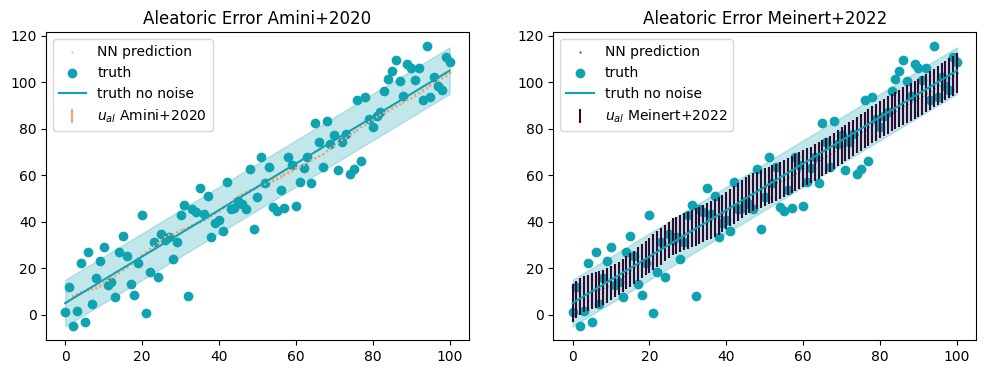

In [18]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [19]:
print, epistemic_OG, epistemic_mod 

(<function print>,
 array([24.165062, 24.310808, 24.70378 , 25.106628, 25.049393, 24.87436 ,
        25.181046, 25.67947 , 25.44884 , 24.894611, 24.199547, 23.709728,
        23.388462, 23.133339, 22.908665, 22.686617, 22.504917, 22.4435  ,
        22.380669, 22.30638 , 22.214859, 22.124706, 22.035889, 21.94848 ,
        21.976334, 22.048182, 22.159874, 22.378462, 22.59988 , 22.823723,
        23.05005 , 23.278885, 23.510204, 23.764408, 24.032536, 24.304031,
        24.57889 , 24.857178, 25.13892 , 25.258017, 25.322792, 25.387747,
        25.45285 , 25.539122, 25.628622, 25.71849 , 25.80953 , 25.9022  ,
        25.995218, 26.088524, 26.182177, 26.27618 , 26.370462, 26.465113,
        26.560045, 26.626108, 26.674679, 26.72324 , 26.771795, 26.82035 ,
        26.868963, 26.958199, 27.078817, 27.276384, 27.480421, 27.685984,
        27.90159 , 28.137243, 28.421978, 28.712612, 29.050138, 29.43816 ,
        29.831581, 30.230469, 30.83363 , 31.554049, 32.292213, 33.048412,
        33.82321 , 

<Figure size 640x480 with 0 Axes>

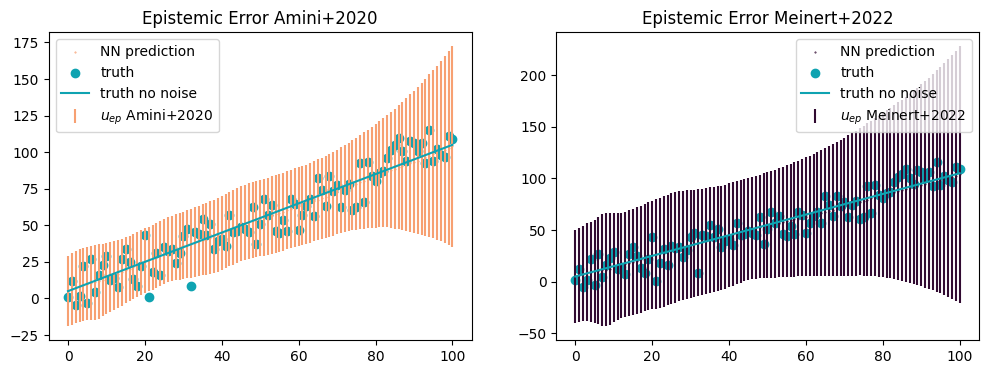

In [20]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()


### Now that intervals are obtained we can apply conformalization
First trying this with the Meinert+2022 aleatoric uncertainty.

In [40]:
labels, labels_pred, upper, lower = y_true, y_pred, y_pred + aleatoric_mod, y_pred - aleatoric_mod

In [41]:
print(np.shape(labels), np.shape(upper), np.shape(lower))

(101,) (101,) (101,)


In [54]:
# Problem setup
n=50
alpha = 0.32 # 1 - alpha is desired coverage, here we're going for 1 sigma or 68%
print(f'Guaranteeing {round(1-alpha,2)*100}% coverage')

Guaranteeing 68.0% coverage


In [55]:
# split the test set into calibration and validation:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (labels.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_labels, val_labels = labels[idx], labels[~idx]
cal_labels_pred, val_labels_pred = labels_pred[idx], labels_pred[~idx]
cal_upper, val_upper = upper[idx], upper[~idx]
cal_lower, val_lower = lower[idx], lower[~idx]
cal_X, val_X = thetas_1d_true[idx], thetas_1d_true[~idx]

In [56]:
# Get scores. cal_upper.shape[0] == cal_lower.shape[0] == n
cal_scores = np.maximum(cal_labels-cal_upper, cal_lower-cal_labels)
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=lower and upper adjusted quantiles)
prediction_sets = [val_lower - qhat, val_upper + qhat]

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_4632/3170777591.py:4: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


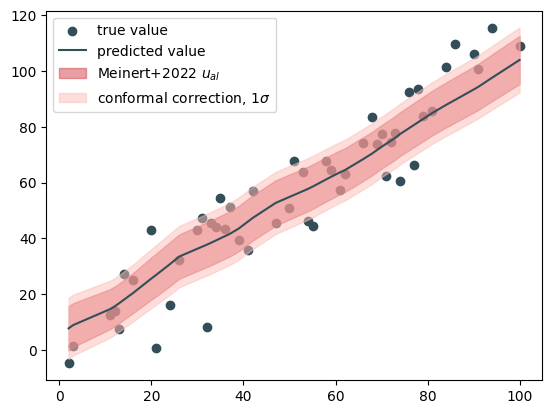

In [57]:
# let's visualize what is happening on the validation set


plt.scatter(val_X[:,0], val_labels, label = 'true value', color = '#334E58')
plt.plot(val_X[:,0], val_labels_pred, label = 'predicted value', color = '#334E58')
plt.fill_between(val_X[:,0], val_lower, val_upper, label = r'Meinert+2022 $u_{al}$', alpha = 0.5, color = '#D33F49')
plt.fill_between(val_X[:,0], prediction_sets[0], prediction_sets[1], label = r'conformal correction, 1$\sigma$', alpha = 0.5, color = '#FCBFB7')
plt.legend()
plt.show()